# Motor Remaining Useful Life (RUL) Prediction: Baseline Pipeline

This notebook demonstrates a baseline approach for predicting the Remaining Useful Life (RUL) of motors. The workflow includes data loading, feature engineering, model training (LinearRegression, XGBoost, CatBoostRegressor), and evaluation. 

---

**Outline:**
1. Import libraries (лайбрарис) and load data
2. Add RUL target variable
3. Aggregate features with rolling window. Feature(ˈfēCHər == фиичар) engineering: derivatives, rolling stats
4. Train/test split
5. LinearRegression
6. Baseline XGBoost Model
7. Baseline Catboost Model

In [ ]:
# Import required libraries (лайбрари)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error
import scipy.stats as st


import shap
pd.set_option('display.max_columns', None)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)

print("XGBoost version:", xgb.__version__)
import catboost
print("CatBoost version:", catboost.__version__)

np.random.seed(324)

In [ ]:
# Load the dataset
df = pd.read_csv('../data/Data.csv')

# Display the first few rows
df.head()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002


## 1. Initial Data Analysis and Visualization

- Check data structure, types, and missing values
- Visualize cycle and sensor distributions


In [ ]:
df.columns

Index(['id', 'cycle', 'p00', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07',
       'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17',
       'p18', 'p19', 'p20', 's1', 's2'],
      dtype='object')

In [ ]:
# Show dataframe info and check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      16138 non-null  int64  
 1   cycle   16138 non-null  int64  
 2   p00     16138 non-null  float64
 3   p01     16138 non-null  float64
 4   p02     16138 non-null  float64
 5   p03     16138 non-null  float64
 6   p04     16138 non-null  float64
 7   p05     16138 non-null  float64
 8   p06     16138 non-null  float64
 9   p07     16138 non-null  float64
 10  p08     16138 non-null  int64  
 11  p09     16138 non-null  int64  
 12  p10     16138 non-null  int64  
 13  p11     16138 non-null  float64
 14  p12     16138 non-null  float64
 15  p13     16138 non-null  float64
 16  p14     16138 non-null  float64
 17  p15     16138 non-null  float64
 18  p16     16138 non-null  float64
 19  p17     16138 non-null  float64
 20  p18     16138 non-null  float64
 21  p19     16138 non-null  float64
 22

In [ ]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
id       0
cycle    0
p00      0
p01      0
p02      0
p03      0
p04      0
p05      0
p06      0
p07      0
p08      0
p09      0
p10      0
p11      0
p12      0
p13      0
p14      0
p15      0
p16      0
p17      0
p18      0
p19      0
p20      0
s1       0
s2       0
dtype: int64


In [ ]:
# Show basic statistics. Sensors p01 and p00, p07, p09, p10, p16 and p17 are not changed
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,16138.0,4.070789e+01,2.339535e+01,1.0000,20.0000,42.0000,61.0000,80.0000
cycle,16138.0,1.055481e+02,6.591530e+01,1.0000,51.0000,101.0000,153.0000,362.0000
p00,16138.0,5.186700e+02,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
p01,16138.0,1.300000e+00,2.220515e-16,1.3000,1.3000,1.3000,1.3000,1.3000
p02,16138.0,4.754426e+01,2.674218e-01,46.8600,47.3500,47.5200,47.7100,48.5300
p03,16138.0,5.214054e+02,7.382523e-01,518.6900,520.9400,521.4600,521.9400,523.3800
p04,16138.0,2.388097e+03,7.260372e-02,2387.8800,2388.0400,2388.0900,2388.1400,2388.5600
p05,16138.0,8.143933e+03,1.973135e+01,8099.9400,8132.8300,8140.7500,8148.8175,8293.7200
p06,16138.0,8.442581e+00,3.751962e-02,8.3249,8.4153,8.4398,8.4660,8.5848
p07,16138.0,3.000000e-02,1.387822e-17,0.0300,0.0300,0.0300,0.0300,0.0300


In [ ]:
df.nunique() # (ˌyo͞oˈnēk == юююник)

id         80
cycle     362
p00         1
p01         1
p02       156
p03       418
p04        56
p05      5707
p06      1871
p07         1
p08        12
p09         1
p10         1
p11       307
p12       116
p13      4518
p14      2899
p15      3865
p16         1
p17         2
p18       502
p19        53
p20      5955
s1        155
s2         13
dtype: int64

In [ ]:
print(df.columns[df.nunique() < 2]) # Identify columns with only one unique value

# Drop columns with only one (ˌyo͞oˈnēk == юююник) value
df = df.loc[:, df.nunique() > 1]

Index(['p00', 'p01', 'p07', 'p09', 'p10', 'p16'], dtype='object')


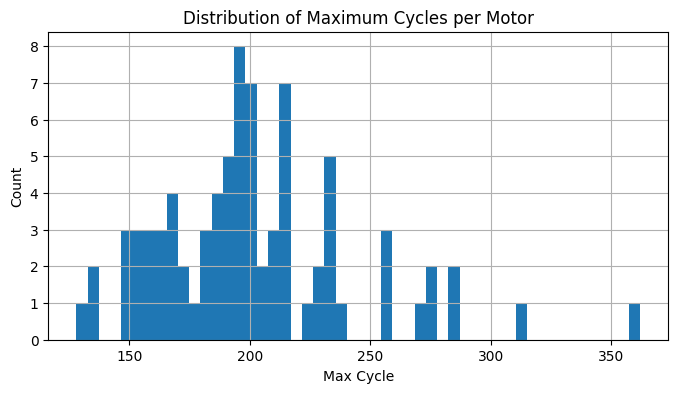

In [ ]:
# Plot distribution of cycles per motor
plt.figure(figsize=(8,4))
df.groupby('id')['cycle'].max().hist(bins=50)
plt.title('Distribution of Maximum Cycles per Motor')
plt.xlabel('Max Cycle')
plt.ylabel('Count')
plt.show()

1. Most motors operate from 170 to 230 cycles - this is where the highest concentration is (the peak of the histogram).  
2. There are individual motors that operate significantly longer (up to 350 cycles), but there are few of them.  
3. The distribution is uneven, there is a small "tail" to the right - individual long-lived specimens.  

## 2. Add RUL (Remaining Useful Life) Target Variable

- For each motor, calculate RUL as the difference between the maximum cycle and the current cycle.


In [10]:
# Calculate RUL for each row 
df_target = df.groupby('id')['cycle'].transform('max')

df['max_cycle'] = df_target.copy()

df['rul'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)

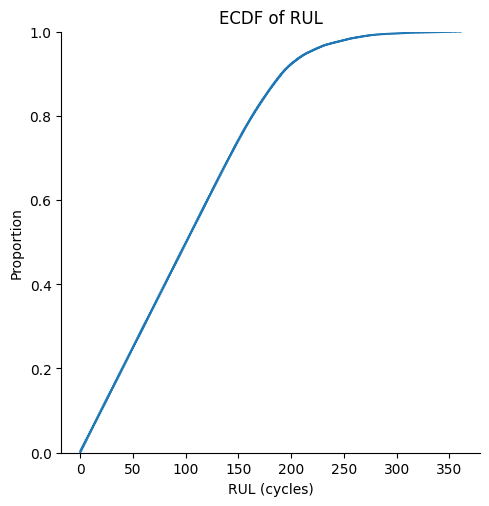

In [ ]:
# ECDF plot for RUL (Remaining Useful Life)
# This plot shows the ECDF (Empirical Cumulative Distribution Function) of RUL. 
# It helps us see the distribution of remaining useful life for all engines.

sns.displot(data=df, x='rul', kind='ecdf')
plt.title('ECDF of RUL')
plt.xlabel('RUL (cycles)')
plt.ylabel('Proportion')
plt.show()

rul      1.000000
cycle    0.769964
p02      0.704527
p15      0.686511
p03      0.678935
p18      0.662448
p06      0.648625
p13      0.646511
p12      0.637581
p11      0.616728
p08      0.613475
p14      0.590030
p04      0.566580
p19      0.566356
p20      0.391014
p05      0.310472
p17      0.133559
id       0.028491
s2       0.002669
s1       0.000150
Name: rul, dtype: float64


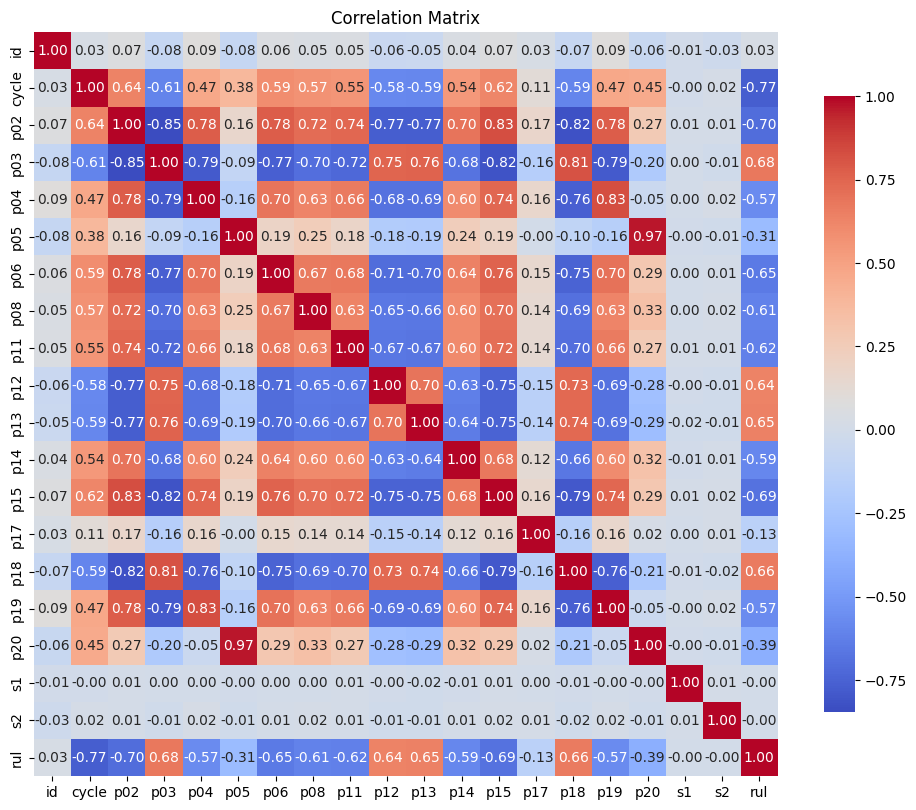

In [ ]:
# Check correlation with RUL. There are p02, p15, p03, p18, p06, p13 that are highly correlated with RUL.
# p20 and p05 are also correlated with each other, but not with RUL.
# Cycle type features also strongly correlate with RUL (as expected, since RUL = max_cycle - cycle).
print(df.corr().abs()['rul'].sort_values(ascending=False))
# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Column like as the cycle is time series data, so we need to create rolling features

# Note: When you create rolling window features, the first (window_size-1) rows for each engine will have NaN values.
# This is normal because there is not enough history for the window.

sensor_cols = ['p02', 'p03', 'p04', 'p05', 'p06', 'p08', 'p11', 'p12',
       'p13', 'p14', 'p15', 'p17', 'p18', 'p19','p20', 's1', 's2']
sensor_cols

['p02',
 'p03',
 'p04',
 'p05',
 'p06',
 'p08',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p17',
 'p18',
 'p19',
 'p20',
 's1',
 's2']

## 3. Aggregate Features with Rolling Window

- For each motor and each cycle, compute rolling window aggregates (mean, std, min, max) for sensor 
- This helps capture recent trends and variability for each engine.


In [ ]:
# Column like as the cycle is time series data, so we need to create rolling features

# Note: When you create rolling window features, the first (window_size-1) rows for each engine will have NaN values.
# This is normal because there is not enough history for the window.
# The most common way is to fill NaN with the mean or median of the column.

# Add difference features for each sensor column
for col in sensor_cols:
    df[f'{col}_diff1'] = df.groupby('id')[col].diff()

def add_rolling_features(df, cols, window):
    """ 
    Function to add rolling features for each column in cols
    using a specified window size.
    """
    new_features = {}
    for func in ['mean', 'std', 'min', 'max']:
        for col in cols:
            new_features[f'{col}_roll{window}_{func}'] = (
                df.groupby('id')[col].transform(lambda x: x.rolling(window, min_periods=1).agg(func))
            )
    df = pd.concat([df, pd.DataFrame(new_features)], axis=1)
    df = df.copy()  # Defragment the DataFrame
    # Fill NaN values with the mean of the column
    for col in new_features.keys():
        df[col] = df[col].fillna(df[col].mean())
    return df

windows = [5, 10, 20, 30, 45, 60, 90, 120, 180, 350]
# Add rolling features for each window size
for window in windows:
    df = add_rolling_features(df, sensor_cols, window)

df[[c for c in df.columns if 'roll' in c]].head()

,p02_roll5_mean,p03_roll5_mean,p04_roll5_mean,p05_roll5_mean,p06_roll5_mean,p08_roll5_mean,p11_roll5_mean,p12_roll5_mean,p13_roll5_mean,p14_roll5_mean,p15_roll5_mean,p17_roll5_mean,p18_roll5_mean,p19_roll5_mean,p20_roll5_mean,s1_roll5_mean,s2_roll5_mean,p02_roll5_std,p03_roll5_std,p04_roll5_std,p05_roll5_std,p06_roll5_std,p08_roll5_std,p11_roll5_std,p12_roll5_std,p13_roll5_std,p14_roll5_std,p15_roll5_std,p17_roll5_std,p18_roll5_std,p19_roll5_std,p20_roll5_std,s1_roll5_std,s2_roll5_std,p02_roll5_min,p03_roll5_min,p04_roll5_min,p05_roll5_min,p06_roll5_min,p08_roll5_min,p11_roll5_min,p12_roll5_min,p13_roll5_min,p14_roll5_min,p15_roll5_min,p17_roll5_min,p18_roll5_min,p19_roll5_min,p20_roll5_min,s1_roll5_min,s2_roll5_min,p02_roll5_max,p03_roll5_max,p04_roll5_max,p05_roll5_max,p06_roll5_max,p08_roll5_max,p11_roll5_max,p12_roll5_max,p13_roll5_max,p14_roll5_max,p15_roll5_max,p17_roll5_max,p18_roll5_max,p19_roll5_max,p20_roll5_max,s1_roll5_max,s2_roll5_max,p02_roll10_mean,p03_roll10_mean,p04_roll10_mean,p05_roll10_mean,p06_roll10_mean,p08_roll10_mean,p11_roll10_mean,p12_roll10_mean,p13_roll10_mean,p14_roll10_mean,p15_roll10_mean,p17_roll10_mean,p18_roll10_mean,p19_roll10_mean,p20_roll10_mean,s1_roll10_mean,s2_roll10_mean,p02_roll10_std,p03_roll10_std,p04_roll10_std,p05_roll10_std,p06_roll10_std,p08_roll10_std,p11_roll10_std,p12_roll10_std,p13_roll10_std,p14_roll10_std,p15_roll10_std,p17_roll10_std,p18_roll10_std,p19_roll10_std,p20_roll10_std,s1_roll10_std,s2_roll10_std,p02_roll10_min,p03_roll10_min,p04_roll10_min,p05_roll10_min,p06_roll10_min,p08_roll10_min,p11_roll10_min,p12_roll10_min,p13_roll10_min,p14_roll10_min,p15_roll10_min,p17_roll10_min,p18_roll10_min,p19_roll10_min,p20_roll10_min,s1_roll10_min,s2_roll10_min,p02_roll10_max,p03_roll10_max,p04_roll10_max,p05_roll10_max,p06_roll10_max,p08_roll10_max,p11_roll10_max,p12_roll10_max,p13_roll10_max,p14_roll10_max,p15_roll10_max,p17_roll10_max,p18_roll10_max,p19_roll10_max,p20_roll10_max,s1_roll10_max,s2_roll10_max,p02_roll20_mean,p03_roll20_mean,p04_roll20_mean,p05_roll20_mean,p06_roll20_mean,p08_roll20_mean,p11_roll20_mean,p12_roll20_mean,p13_roll20_mean,p14_roll20_mean,p15_roll20_mean,p17_roll20_mean,p18_roll20_mean,p19_roll20_mean,p20_roll20_mean,s1_roll20_mean,s2_roll20_mean,p02_roll20_std,p03_roll20_std,p04_roll20_std,p05_roll20_std,p06_roll20_std,p08_roll20_std,p11_roll20_std,p12_roll20_std,p13_roll20_std,p14_roll20_std,p15_roll20_std,p17_roll20_std,p18_roll20_std,p19_roll20_std,p20_roll20_std,s1_roll20_std,s2_roll20_std,p02_roll20_min,p03_roll20_min,p04_roll20_min,p05_roll20_min,p06_roll20_min,p08_roll20_min,p11_roll20_min,p12_roll20_min,p13_roll20_min,p14_roll20_min,p15_roll20_min,p17_roll20_min,p18_roll20_min,p19_roll20_min,p20_roll20_min,s1_roll20_min,s2_roll20_min,p02_roll20_max,p03_roll20_max,p04_roll20_max,p05_roll20_max,p06_roll20_max,p08_roll20_max,p11_roll20_max,p12_roll20_max,p13_roll20_max,p14_roll20_max,p15_roll20_max,p17_roll20_max,p18_roll20_max,p19_roll20_max,p20_roll20_max,s1_roll20_max,s2_roll20_max,p02_roll30_mean,p03_roll30_mean,p04_roll30_mean,p05_roll30_mean,p06_roll30_mean,p08_roll30_mean,p11_roll30_mean,p12_roll30_mean,p13_roll30_mean,p14_roll30_mean,p15_roll30_mean,p17_roll30_mean,p18_roll30_mean,p19_roll30_mean,p20_roll30_mean,s1_roll30_mean,s2_roll30_mean,p02_roll30_std,p03_roll30_std,p04_roll30_std,p05_roll30_std,p06_roll30_std,p08_roll30_std,p11_roll30_std,p12_roll30_std,p13_roll30_std,p14_roll30_std,p15_roll30_std,p17_roll30_std,p18_roll30_std,p19_roll30_std,p20_roll30_std,s1_roll30_std,s2_roll30_std,p02_roll30_min,p03_roll30_min,p04_roll30_min,p05_roll30_min,p06_roll30_min,p08_roll30_min,p11_roll30_min,p12_roll30_min,p13_roll30_min,p14_roll30_min,p15_roll30_min,p17_roll30_min,p18_roll30_min,p19_roll30_min,p20_roll30_min,s1_roll30_min,s2_roll30_min,p02_roll30_max,p03_roll30_max,p04_roll30_max,p05_roll30_max,p06_roll30_max,p08_roll30_max,p11_roll30_max,p12_roll30_max,p13_roll30_max,p14_roll30_max,p15_roll30_max,p17_roll30_max,p18_roll30_max,p19_roll3

In [15]:
def add_rolling_trend(df, cols, window):
    """
    Function to add rolling trend features for each column in cols
    using a specified window size.
    The trend is calculated using a linear regression fit (slope).
    
    """
    def trend(x):
        idx = np.arange(len(x))
        if len(x) < 2:
            return 0.0
        return np.polyfit(idx, x, 1)[0]
    new_features = {}
    for col in cols:
        new_features[f'{col}_roll{window}_trend'] = (
            df.groupby('id')[col]
              .transform(lambda x: x.rolling(window, min_periods=2).apply(trend, raw=True))
        )
    df = pd.concat([df, pd.DataFrame(new_features, index=df.index)], axis=1)
    df = df.copy()  
    return df


for w in windows:
    df = add_rolling_trend(df, sensor_cols, w)

In [ ]:
from sklearn.impute import SimpleImputer

# Fill NaN values in rolling features with the mean of the column
# This is necessary because rolling features will have NaN values for the first (window_size-1) rows
# and for any rows where there is not enough data to calculate the rolling feature  

rolling_cols = [c for c in df.columns if 'roll' in c or 'diff1' in c]
imputer = SimpleImputer(strategy='mean')
df[rolling_cols] = imputer.fit_transform(df[rolling_cols])

## 4. Train/Test Split

- Split the data into training and test sets. We will use the last 20 cycles of each engine as the test set. The rest will be used for training.


In [17]:
# Create bins for RUL to stratify the split
# This helps to ensure that both training and test sets have a similar distribution of RUL values
# We use pd.qcut to create quantile-based bins, which helps in stratifying the split
# The 'duplicates' parameter is set to 'drop' to avoid issues with bins that have the same edges
# This is useful when the RUL values are not evenly distributed


In [18]:
# Create bins for RUL to stratify the split
id_rul = df.groupby('id')['rul'].max().reset_index()
id_rul['rul_bin'] = pd.qcut(id_rul['rul'], q=10, duplicates='drop')
id_rul['rul_bin']

0       (179.7, 191.0]
1       (256.2, 361.0]
2       (166.6, 179.7]
3       (179.7, 191.0]
4       (256.2, 361.0]
            ...       
75      (201.0, 212.0]
76    (126.999, 154.8]
77      (229.2, 256.2]
78      (194.5, 201.0]
79      (179.7, 191.0]
Name: rul_bin, Length: 80, dtype: category
Categories (10, interval[float64, right]): [(126.999, 154.8] < (154.8, 166.6] < (166.6, 179.7] < (179.7, 191.0] ... (201.0, 212.0] < (212.0, 229.2] < (229.2, 256.2] < (256.2, 361.0]]

In [19]:
# Split the data into training and test sets, stratifying by the RUL bins
train_ids, test_ids = train_test_split(
    id_rul['id'],
    test_size=0.2,
    random_state=42,
    stratify=id_rul['rul_bin']
)

In [20]:
# Form train and test sets based on the selected ids
train_df = df[df['id'].isin(train_ids)].copy()
test_df = df[df['id'].isin(test_ids)].copy()

print(train_df['rul'].describe())
print(test_df['rul'].describe())

count    12950.000000
mean       105.060541
std         66.524506
min          0.000000
25%         50.000000
50%        101.000000
75%        152.000000
max        361.000000
Name: rul, dtype: float64
count    3188.000000
mean      102.466750
std        63.347968
min         0.000000
25%        49.000000
50%        99.000000
75%       149.000000
max       282.000000
Name: rul, dtype: float64


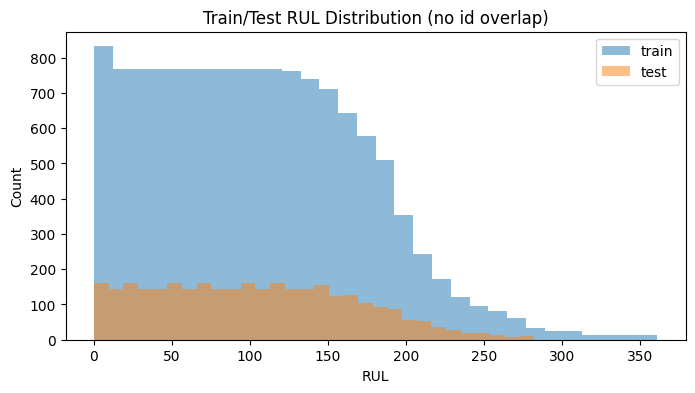

In [21]:
# Visualize the distribution of RUL in train and test sets


plt.figure(figsize=(8,4))
plt.hist(train_df['rul'], bins=30, alpha=0.5, label='train')
plt.hist(test_df['rul'], bins=30, alpha=0.5, label='test')
plt.xlabel('RUL')
plt.ylabel('Count')
plt.legend()
plt.title('Train/Test RUL Distribution (no id overlap)')
plt.show()

In [ ]:
from scipy.stats import ks_2samp

# Perform the Kolmogorov-Smirnov test to compare the distributions of RUL in train and test sets
# This test checks if the two samples come from the same distribution
# A high p-value (> 0.05) indicates that the distributions are similar, while a low p-value (< 0.05) indicates that they are different

stat, p_value = ks_2samp(train_df['rul'], test_df['rul'])
print(f"KS statistic: {stat:.4f}, p-value: {p_value:.4f}")

if p_value > 0.05:
    print("rul distributions in train and test are statistically similar.")
else:
    print("rul distributions in train and test are statistically different.")



KS statistic: 0.0152, p-value: 0.5918
rul distributions in train and test are statistically similar.


In [ ]:
feature_cols = [col for col in train_df.columns if col not in ['rul', 'id', 'cycle']]
X_train = train_df[feature_cols]
y_train = train_df['rul']
X_test = test_df[feature_cols]
y_test = test_df['rul']

# Scale the features using StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# search and remove features with high correlation (> 0.95) for liner regression
# This is important because linear regression assumes that features are not highly correlated
# High correlation can lead to multicollinearity, which can affect the stability and interpretability
# of the regression coefficients.
corr_matrix = pd.DataFrame(X_train_scaled, columns=feature_cols).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("Will be delete features with high correlation:", to_drop)

# Delete from train/test
X_train_reduced = pd.DataFrame(X_train_scaled, columns=feature_cols).drop(columns=to_drop)
X_test_reduced = pd.DataFrame(X_test_scaled, columns=feature_cols).drop(columns=to_drop)

Will be delete features with high correlation: ['p20', 'p03_roll5_mean', 'p05_roll5_mean', 'p15_roll5_mean', 'p18_roll5_mean', 'p19_roll5_mean', 'p20_roll5_mean', 'p17_roll5_std', 'p02_roll5_min', 'p03_roll5_min', 'p04_roll5_min', 'p05_roll5_min', 'p06_roll5_min', 'p13_roll5_min', 'p15_roll5_min', 'p17_roll5_min', 'p18_roll5_min', 'p19_roll5_min', 'p20_roll5_min', 'p02_roll5_max', 'p03_roll5_max', 'p04_roll5_max', 'p05_roll5_max', 'p06_roll5_max', 'p12_roll5_max', 'p13_roll5_max', 'p15_roll5_max', 'p18_roll5_max', 'p19_roll5_max', 'p20_roll5_max', 'p02_roll10_mean', 'p03_roll10_mean', 'p04_roll10_mean', 'p05_roll10_mean', 'p06_roll10_mean', 'p08_roll10_mean', 'p11_roll10_mean', 'p12_roll10_mean', 'p13_roll10_mean', 'p14_roll10_mean', 'p15_roll10_mean', 'p18_roll10_mean', 'p19_roll10_mean', 'p20_roll10_mean', 'p02_roll10_min', 'p03_roll10_min', 'p04_roll10_min', 'p05_roll10_min', 'p15_roll10_min', 'p17_roll10_min', 'p18_roll10_min', 'p19_roll10_min', 'p20_roll10_min', 'p02_roll10_max', 

## 5 LinearRegression

In [ ]:
# Function for printing metrics and visualizing results
# This function calculates and prints the main metrics (MAE, RMSE) for the predictions
# It also analyzes the errors by RUL ranges and visualizes the results. 

def print_metrics(y_test, y_pred):
    # Main metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"MAE (all): {mae:.2f}")
    print(f"RMSE (all): {rmse:.2f}")

    # there are some engines with RUL > 200, so we need to analyze errors by ranges
    bins = [0, 60, 100, 200, np.inf]
    labels = ['<=60','60-100','100-200', '>200']
    y_test_bins = pd.cut(y_test, bins=bins, labels=labels)

    for label in labels:
        mask = y_test_bins == label
        if mask.sum() == 0:
            continue
        mae_bin = mean_absolute_error(y_test[mask], np.array(y_pred)[mask])
        rmse_bin = np.sqrt(mean_squared_error(y_test[mask], np.array(y_pred)[mask]))
        print(f"\nRange RUL {label}:")
        print(f"  MAE: {mae_bin:.2f}")
        print(f"  RMSE: {rmse_bin:.2f}")

    # Visualization
    plt.figure(figsize=(8,4))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.title('Predicted vs True RUL')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')
    plt.show()
    # Visualize errors for RUL <= 60
    mask_short = y_test <= 60
    errors = y_test[mask_short] - y_pred[mask_short]

    plt.figure(figsize=(12,6))
    plt.hist(errors, bins=40, alpha=0.7)
    plt.title('(True RUL - Predicted RUL) for RUL ≤ 60')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.xlim(-60, 30)
    # Calculate errors and visualize confidence intervals 
    
    mean_err = np.mean(errors)
    sem = st.sem(errors)
    plt.axvline(mean_err, color='red', linestyle='--', label='Mean error')
    plt.legend()
    plt.show()
    
    # Weighted MAE
    # We consider errors for RUL <= 60 three times more important
    weights = np.where(y_test <= 60, 3, 1)  
    weighted_mae = np.sum(weights * np.abs(y_test - y_pred)) / np.sum(weights)
    print(f"weighted MAE: {weighted_mae:.2f}")

def plot_feature_importances(model, X_train):
    importances = model.feature_importances_
    feature_names = X_train.columns

    # top 20 most important features
    indices = np.argsort(importances)[::-1][:20]
    plt.figure(figsize=(10,6))
    plt.title("Feature importances (XGBoost)")
    plt.bar(range(len(indices)), importances[indices], align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
def plot_feature_importances_catboost(model, X_train):
    importances = model.get_feature_importance()
    feature_names = X_train.columns
    indices = np.argsort(importances)[::-1][:20]
    plt.figure(figsize=(10,6))
    plt.title("Feature importances (CatBoost)")
    plt.bar(range(len(indices)), importances[indices], align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
def plot_shap_values(model, X_test):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    # Summary plot
    shap.summary_plot(shap_values, X_test, max_display=20)


In [26]:
def compute_s_score(rul_true, rul_pred):
    """
    Compute S-score based on the difference between predicted and true RUL.
    The S-score is a measure of the accuracy of the RUL predictions.
    It penalizes overestimation (late prediction) much more than underestimation (early prediction).
    np.exp(diff/10)-1  is used for overestimation (diff > 0), np.exp(-diff/13)-1 for underestimation (diff <= 0).
    The constants 10 and 13 are chosen based on the problem domain and can be adjusted
    to change the sensitivity of the score to errors.
    Parameters:
    rul_true (array-like): True RUL values.
    rul_pred (array-like): Predicted RUL values.
    Returns:
    float: The computed S-score.
    If you want to increase the penalty for overestimation, you can reduce the denominator for np.exp(diff/10)-1.
    For example, changing it to np.exp(diff/7)-1 will increase the penalty for overestimation.
    If you want to increase the penalty for underestimation, you can reduce the denominator for np.exp(-diff/13)-1.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff > 0, np.exp(diff/10)-1, np.exp(-diff/13)-1))

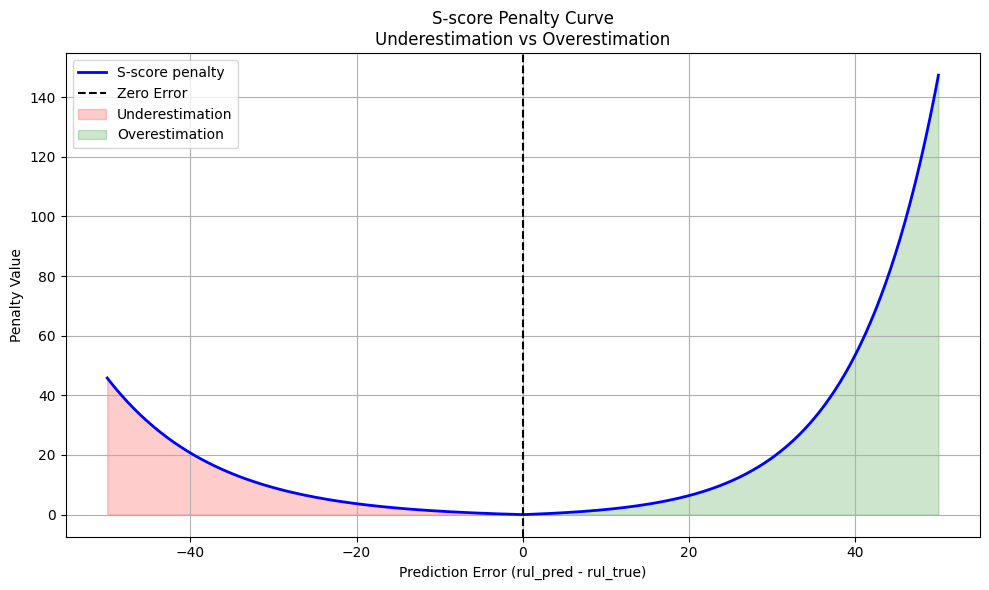

In [ ]:
# I create a plot for S-score penalty curve 
# This plot visualizes the penalty for overestimation and underestimation of RUL predictions.
# The x-axis represents the prediction error (difference between predicted and true RUL),
# while the y-axis shows the penalty value.
# The curve is designed to show how the penalty increases for overestimation and underestimation
# The blue line represents the S-score penalty, with a dashed line at zero error.
# The shaded areas indicate the regions of underestimation (red) and overestimation (green).
# The penalty increases exponentially for both overestimation and underestimation, but the rate
# of increase is different, reflecting the higher penalty for overestimation.
# The plot helps to visualize the trade-off between overestimation and underestimation in RUL predictions. 
diff_range = np.linspace(-50, 50, 500)

penalty_values = np.where(diff_range > 0, np.exp(diff_range / 10) - 1, np.exp(-diff_range / 13) - 1)

plt.figure(figsize=(10, 6))
plt.plot(diff_range, penalty_values, color='blue', linewidth=2, label='S-score penalty')
plt.axvline(x=0, color='black', linestyle='--', label='Zero Error')
plt.fill_between(diff_range, penalty_values, where=(diff_range < 0), color='red', alpha=0.2, label='Underestimation')
plt.fill_between(diff_range, penalty_values, where=(diff_range > 0), color='green', alpha=0.2, label='Overestimation')
plt.title('S-score Penalty Curve\nUnderestimation vs Overestimation')
plt.xlabel('Prediction Error (rul_pred - rul_true)')
plt.ylabel('Penalty Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Train Linear Regression model refration and evaluate them
# Linear Regression is a simple model that can be used as a baseline for comparison with more complex models.
lr = LinearRegression()
lr.fit(X_train_reduced, y_train)
y_pred_lr = lr.predict(X_test_reduced)

# S-metrics on test
s_score = compute_s_score(y_test.values, y_pred_lr)
print("S-score LinearRegression:", s_score)
print("LinearRegression MAE:", mean_absolute_error(y_test, y_pred_lr))

S-score LinearRegression: 115891995.66293593
LinearRegression MAE: 26.64047202698629
mean S-score LinearRegression for CV: 4.79514995820754e+18


MAE (all): 26.64
RMSE (all): 34.24

Range RUL <=60:
  MAE: 19.26
  RMSE: 23.76

Range RUL 60-100:
  MAE: 28.29
  RMSE: 33.76

Range RUL 100-200:
  MAE: 26.70
  RMSE: 33.36

Range RUL >200:
  MAE: 53.78
  RMSE: 65.64


/tmp/ipykernel_38970/1777821064.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')


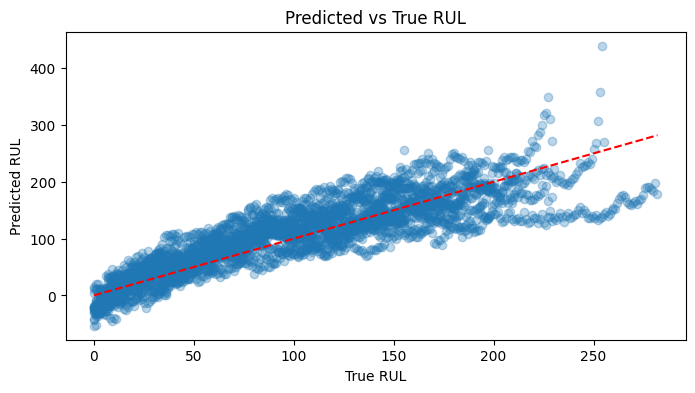

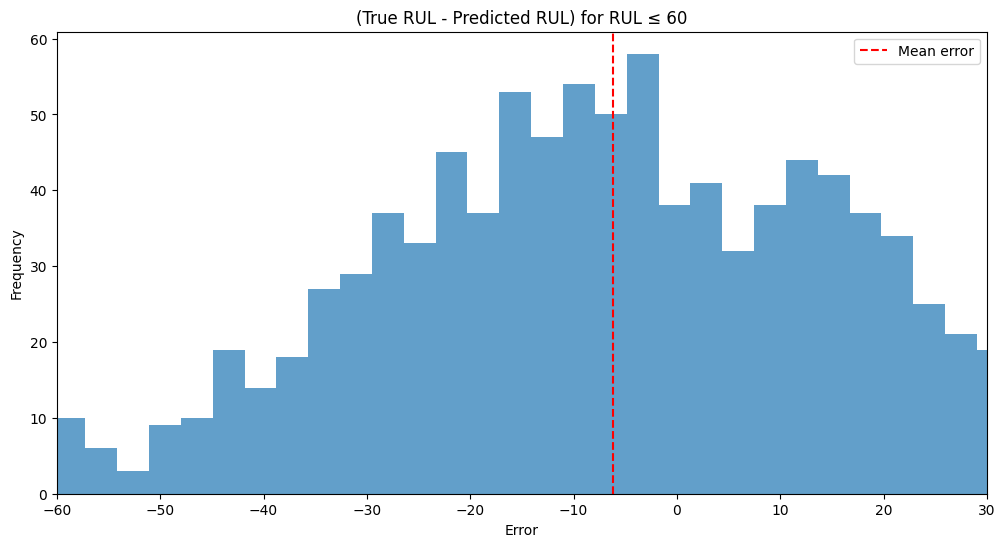

weighted MAE: 23.87


In [ ]:
# Print metrics and visualize results for Linear Regression 
# First graph is scatter plot of predicted vs true RUL. This plot helps to visualize the performance of the model. 
# There are frequency(ˈfrēkwənsē) from erros predictions. 
# Second graph is histogram of errors for RUL <= 60. 
# This helps to understand how well the model performs for short-term predictions. 

print_metrics(y_test, y_pred_lr)

## 6. Baseline XGBoost Model

- We will train a simple XGBoost model to predict RUL. We use only the rolling window features, derivatives, and PCA features.


In [ ]:
# train XGBoost model 
model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
model_xgb.fit(X_train_scaled , y_train)
y_pred_xgb = model_xgb.predict(X_test_scaled)


s_score_scorer = make_scorer(compute_s_score, greater_is_better=False)
cv_scores_s = cross_val_score(
    model_xgb, X_train_scaled, y_train, cv=5, scoring=s_score_scorer
)
print("mean S-score по CV:", -cv_scores_s.mean())

# S-metrics на тесте
s_score = compute_s_score(y_test.values, y_pred_xgb)
print("S-score XGBRegressor:", s_score)

mean S-score по CV: 22550791.849330027
S-score XGBRegressor: 224635.4460028905


MAE (all): 18.48
RMSE (all): 26.39

Range RUL <=60:
  MAE: 6.77
  RMSE: 10.51

Range RUL 60-100:
  MAE: 17.70
  RMSE: 23.07

Range RUL 100-200:
  MAE: 21.16
  RMSE: 25.57

Range RUL >200:
  MAE: 56.53
  RMSE: 63.61


/tmp/ipykernel_38970/1777821064.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')


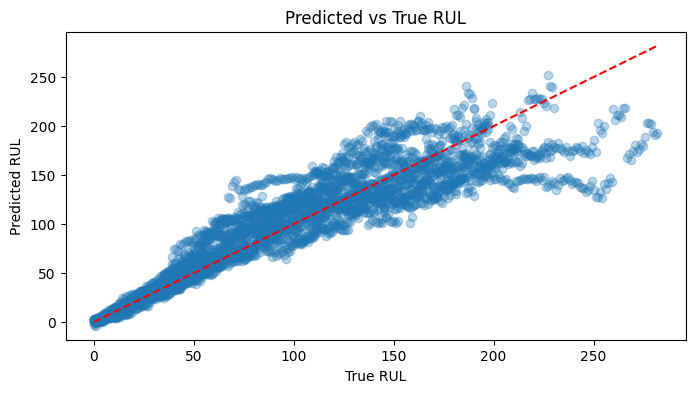

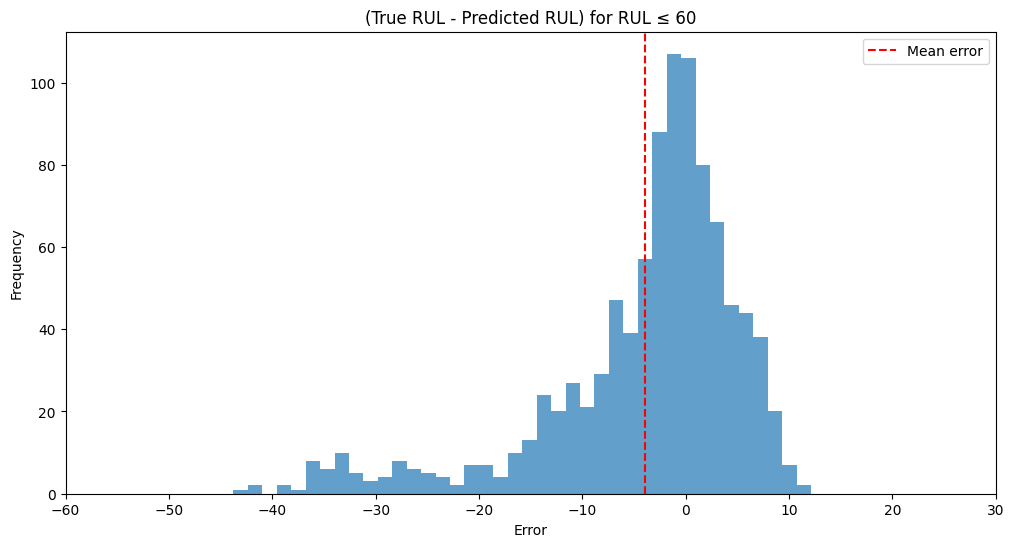

weighted MAE: 14.00


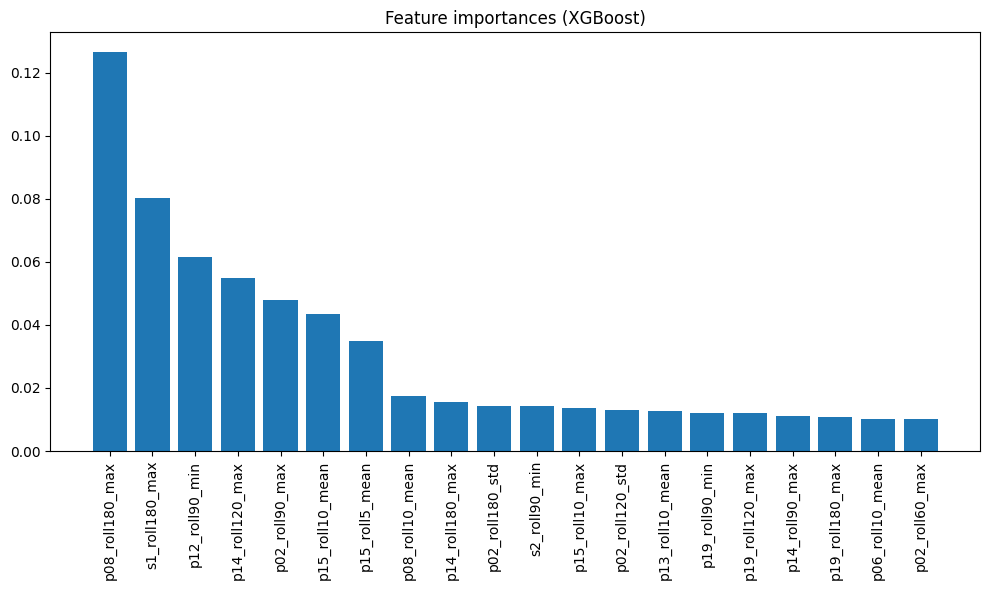

/tmp/ipykernel_38970/1777821064.py:83: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, max_display=20)


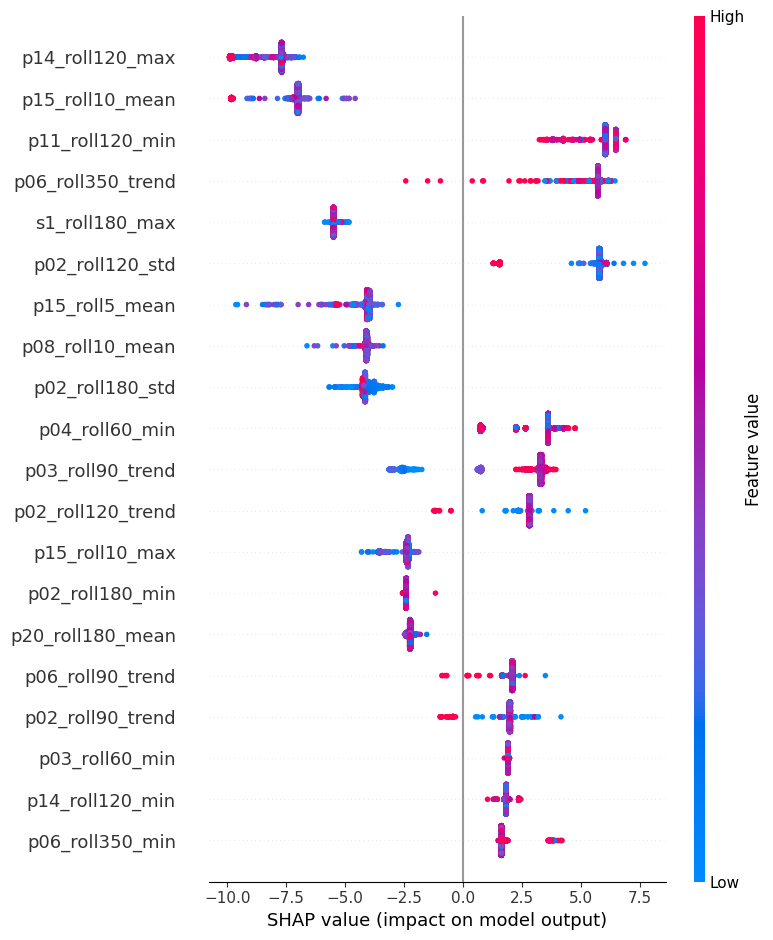

In [ ]:

print_metrics(y_test, y_pred_xgb)
# Print metrics and visualize results for XGBoost
# First graph is scatter plot of predicted vs true RUL. This plot helps to visualize the performance of the model.
# Second graph is histogram of errors for RUL <= 60.
plot_feature_importances(model_xgb, X_train)
# Plot SHAP values for XGBoost model
plot_shap_values(model_xgb, X_test)
# SHAP values help to understand the contribution of each feature to the model's predictions.
# They provide insights into how the model makes decisions and which features are most important.


Rolling and trend features by sensors are key to the RUL prediction task. High values of some features increase the forecast, while others decrease it. SHAP graphs help explain why the model makes a particular prediction and identify the most important parameters for monitoring the motor condition.

Types of features
The most important features are aggregated ones: moving averages, maximums, minimums and trends by sensors for different windows. This confirms that the dynamics and recent changes of sensors are critical for assessing the remaining resource.

## 7. Baseline Catboost Model

In [32]:
# CatBoost
model_cat = CatBoostRegressor(
    early_stopping_rounds=50, iterations=1000, learning_rate=0.1, depth=5, random_seed=42, verbose=100
)

# Cross - validation
s_score_scorer = make_scorer(compute_s_score, greater_is_better=False)

cv_scores_s_cat = cross_val_score(
    model_cat, X_train, y_train, cv=5, scoring=s_score_scorer
)
print("mean S-score CatBoost from CV:", -cv_scores_s_cat.mean())

model_cat.fit(X_train, y_train)
y_pred_cat = model_cat.predict(X_test)
s_score_cat = compute_s_score(y_test.values, y_pred_cat)
print("S-score CatBoost:", s_score_cat)

0:	learn: 61.6401250	total: 162ms	remaining: 2m 42s
100:	learn: 9.1966153	total: 10.5s	remaining: 1m 33s
200:	learn: 5.8355644	total: 19.5s	remaining: 1m 17s


300:	learn: 4.4552189	total: 29.7s	remaining: 1m 9s
400:	learn: 3.7043746	total: 42s	remaining: 1m 2s
500:	learn: 3.2038773	total: 51.5s	remaining: 51.3s
600:	learn: 2.8540024	total: 1m	remaining: 40.3s
700:	learn: 2.5524286	total: 1m 10s	remaining: 30s
800:	learn: 2.3206164	total: 1m 19s	remaining: 19.7s
900:	learn: 2.1200409	total: 1m 28s	remaining: 9.7s
999:	learn: 1.9528302	total: 1m 37s	remaining: 0us
0:	learn: 63.0296873	total: 104ms	remaining: 1m 43s
100:	learn: 9.2127490	total: 9.69s	remaining: 1m 26s
200:	learn: 5.8367047	total: 19s	remaining: 1m 15s
300:	learn: 4.5309877	total: 29s	remaining: 1m 7s
400:	learn: 3.7874502	total: 39.2s	remaining: 58.5s
500:	learn: 3.2776977	total: 49.7s	remaining: 49.5s
600:	learn: 2.9102972	total: 1m	remaining: 40.4s
700:	learn: 2.6026169	total: 1m 11s	remaining: 30.3s
800:	learn: 2.3686649	total: 1m 20s	remaining: 20s
900:	learn: 2.1551455	total: 1m 30s	remaining: 9.98s
999:	learn: 1.9711964	total: 1m 40s	remaining: 0us
0:	learn: 63.6405884	to

MAE (all): 17.12
RMSE (all): 23.83

Range RUL <=60:
  MAE: 6.91
  RMSE: 10.02

Range RUL 60-100:
  MAE: 15.81
  RMSE: 20.17

Range RUL 100-200:
  MAE: 20.50
  RMSE: 25.67

Range RUL >200:
  MAE: 45.83
  RMSE: 50.53


/tmp/ipykernel_38970/1777821064.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')


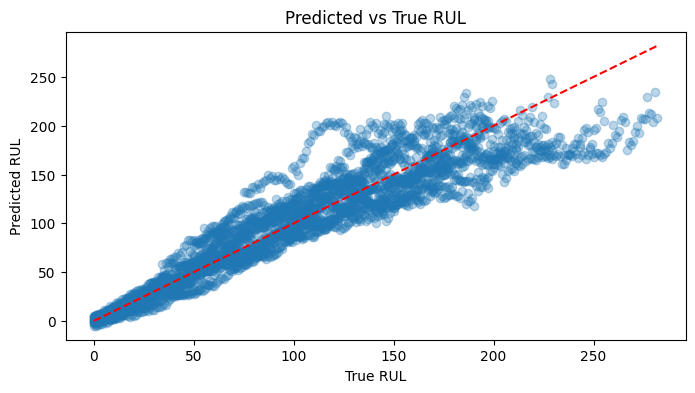

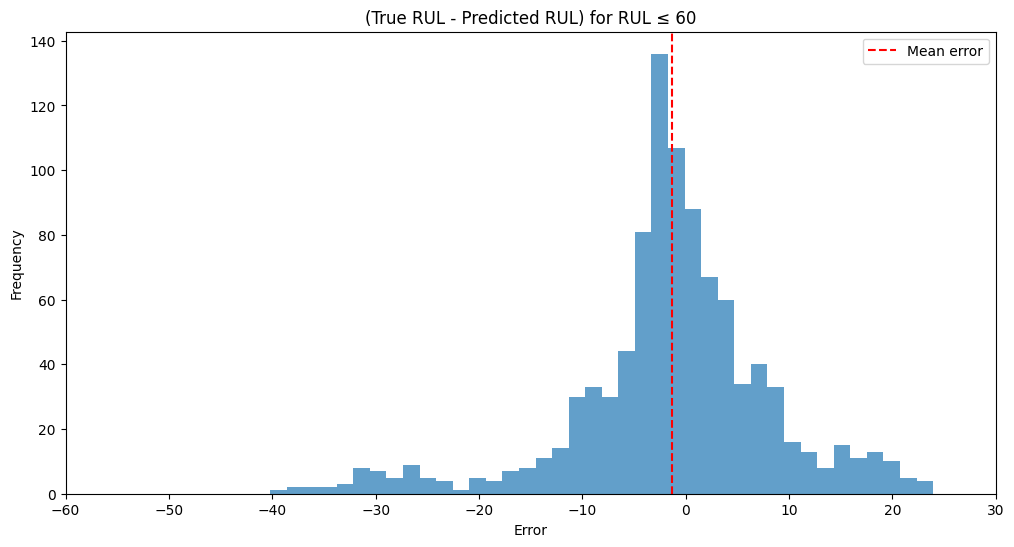

weighted MAE: 13.22


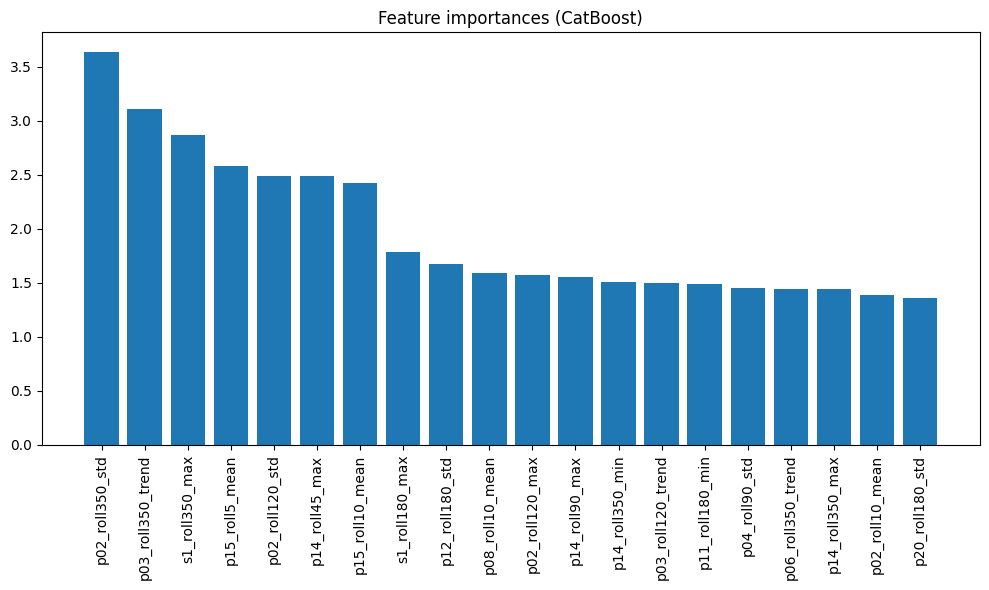

/tmp/ipykernel_38970/1777821064.py:83: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, max_display=20)


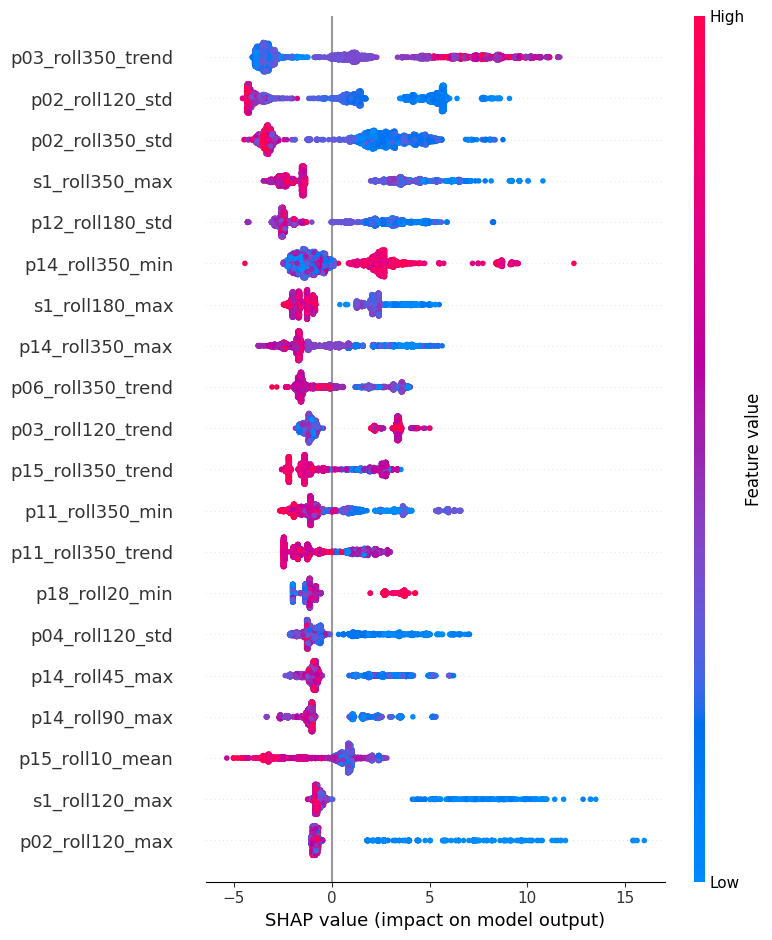

In [33]:
print_metrics(y_test, y_pred_cat)
plot_feature_importances_catboost(model_cat, X_train)
plot_shap_values(model_cat, X_test)

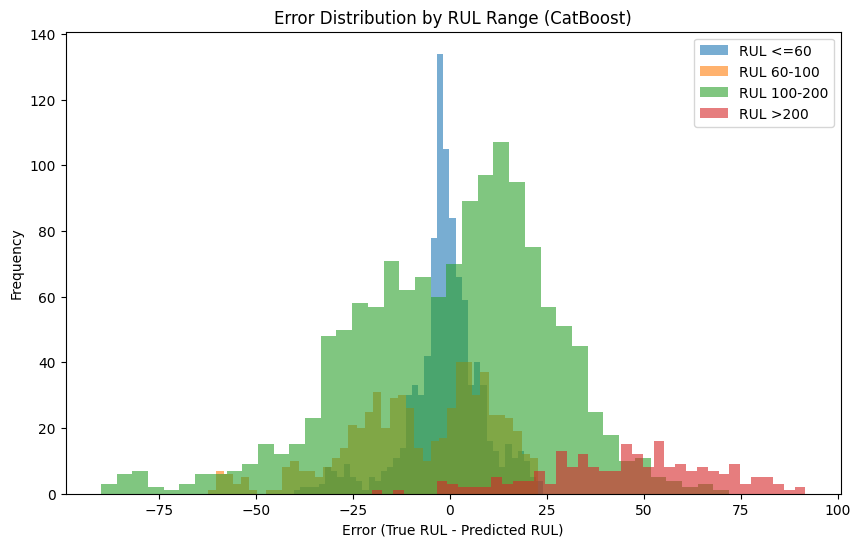

In [ ]:
# Analyze errors by RUL ranges 
# This section analyzes the errors in RUL predictions by categorizing them into different ranges.
# It calculates the errors and visualizes the distribution of errors for each RUL range.
# The bins are defined as follows:
# - <=60: RUL values less than or equal to 60
# - 60-100: RUL values between 60 and 100
# - 100-200: RUL values between 100 and 200
# - >200: RUL values greater than 200
# The errors are calculated as the difference between true RUL and predicted RUL.
# The distribution of errors is visualized using histograms for each RUL range.
errors = y_test - y_pred_cat
bins = [0, 60, 100, 200, np.inf]
labels = ['<=60','60-100','100-200', '>200']
rul_bins = pd.cut(y_test, bins=bins, labels=labels)

plt.figure(figsize=(10,6))
for label in labels:
    mask = rul_bins == label
    plt.hist(errors[mask], bins=40, alpha=0.6, label=f'RUL {label}')
plt.xlabel('Error (True RUL - Predicted RUL)')
plt.ylabel('Frequency')
plt.title('Error Distribution by RUL Range (CatBoost)')
plt.legend()
plt.show()

## hyperparameters and best cross-validated S-score for CatBoost


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for CatBoost hyperparameter tuning
param_grid = {
    'depth': [4, 5, 6],         # Tree depth
    'learning_rate': [0.03, 0.1, 0.2],  # Learning rate
    'iterations': [500, 1000]   # Number of boosting iterations
}

# Initialize CatBoostRegressor with early stopping
catboost_model = CatBoostRegressor(
    early_stopping_rounds=50, random_seed=42, verbose=0
)

# Set up GridSearchCV for CatBoost
# scoring uses custom S-score metric (greater_is_better=False means lower is better)
grid_search = GridSearchCV(
    catboost_model,
    param_grid,
    cv=3,  # Number of folds for cross-validation
    scoring=make_scorer(compute_s_score, greater_is_better=False),
    n_jobs=-1  # Use all available CPU cores
)

# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Print best hyperparameters and best cross-validated S-score
print("Best params:", grid_search.best_params_)
print("Best S-score (CV):", -grid_search.best_score_)

In [ ]:
# Get the best CatBoost model from GridSearchCV
best_cat = grid_search.best_estimator_

# Predict RUL on the test set using the best model
y_pred_best_cat = best_cat.predict(X_test)

# Calculate S-score for the best CatBoost model on the test set
s_score_best_cat = compute_s_score(y_test.values, y_pred_best_cat)
print("S-score CatBoost (best params):", s_score_best_cat)

# Extract mean and std of test scores for each parameter combination
mean_test_scores = grid_search.cv_results_['mean_test_score']
std_test_scores = grid_search.cv_results_['std_test_score']
split_scores = [grid_search.cv_results_[f'split{i}_test_score'] for i in range(grid_search.cv)]

# Print S-score for each fold and parameter combination
for i, params in enumerate(grid_search.cv_results_['params']):
    print(f"Params: {params}")
    for fold, score in enumerate([grid_search.cv_results_[f'split{fold}_test_score'][i] for fold in range(grid_search.cv)]):
        print(f"  Fold {fold+1}: S-score = {-score:.2f}")  # S-score is negative because greater_is_better=False
    print(f"  Mean S-score: {-mean_test_scores[i]:.2f} ± {std_test_scores[i]:.2f}\n")

In [ ]:
print_metrics(y_test, y_pred_best_cat)
plot_feature_importances_catboost(best_cat, X_train)
plot_shap_values(best_cat, X_test)
plot_error_distribution(y_test, y_pred_best_cat)